In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

In [2]:
cohorts = [
    "WEAKENED_IMMUNE_SYSTEM",
    "AGE_50_TO_64",
    "AGE_65_TO_74",
    "AGE_75_AND_OVER",
    "ALL_HEALTH_CARE_WORKERS",
    "ALL_SOCIAL_CARE_WORKERS",
    "18_TO_64_FLU_AT_RISK",
    "OLDER_PEOPLE_CARE_HOME"
]

df = pd.read_parquet('INPUT DATA PATH HERE')
pd.options.display.float_format = '{:,.4f}'.format


In [3]:
df.head()
df.describe()

,patient_sex,patient_age,SIMD_quintile,UR8_2022,attended_vaccination_event
count,"9,169,749.0000","9,169,749.0000","9,169,749.0000","9,169,749.0000","9,169,749.0000"
mean,0.5525,58.5074,2.9640,2.5994,0.5470
std,0.4972,14.6035,1.3970,2.0069,0.4978
min,0.0000,18.0000,1.0000,1.0000,0.0000
25%,0.0000,52.0000,2.0000,1.0000,0.0000
50%,1.0000,59.0000,3.0000,2.0000,1.0000
75%,1.0000,67.0000,4.0000,3.0000,1.0000
max,1.0000,115.0000,5.0000,8.0000,1.0000


In [4]:
summary = df.groupby("cohort_group_ML_analysis")["attended_vaccination_event"].agg(["count", "mean"]).reset_index()
summary

,cohort_group_ML_analysis,count,mean
0,18_TO_64_FLU_AT_RISK,2641889,0.4426
1,AGE_50_TO_64,2955486,0.4814
2,AGE_65_TO_74,1280465,0.7179
3,AGE_75_AND_OVER,1135240,0.8091
4,ALL_HEALTH_CARE_WORKERS,453703,0.4507
5,ALL_SOCIAL_CARE_WORKERS,288363,0.3721
6,OLDER_PEOPLE_CARE_HOME,84980,0.8560
7,WEAKENED_IMMUNE_SYSTEM,329623,0.6118


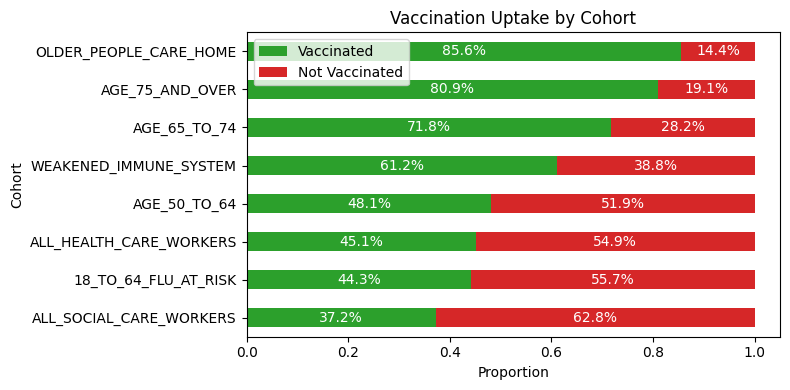

In [5]:

summary = df.groupby('cohort_group_ML_analysis')['attended_vaccination_event'].value_counts(normalize=True).unstack().fillna(0)

# Rename columns for clarity
summary.columns = ['Not Vaccinated', 'Vaccinated'] # = is not vaccinated. 1 is vaccinated
summary = summary[['Vaccinated', 'Not Vaccinated']] # Ensure correct order

# Sort by Uptake in ascending order
summary_sorted = summary.sort_values(by='Vaccinated', ascending=True)

# Plotting
fig, ax = plt.subplots(figsize=(8, 4))
summary_sorted.plot(kind='barh', stacked=True, ax=ax, color=['#2ca02c', '#d62728'])

# Add text labels inside the bars
for i, (vaccinated, not_vaccinated) in enumerate(zip(summary_sorted['Vaccinated'], summary_sorted['Not Vaccinated'])):
    ax.text(vaccinated / 2, i, f"{vaccinated:.1%}", va='center', ha='center', color='white', fontsize=10)
    ax.text(vaccinated + not_vaccinated / 2, i, f"{not_vaccinated:.1%}", va='center', ha='center', color='white', fontsize=10)

ax.set_xlabel("Proportion")
ax.set_ylabel("Cohort")
ax.set_title("Vaccination Uptake by Cohort")
plt.tight_layout()
plt.savefig("FULL_COHORT_ANALYSIS_Vaccination_Uptake_By_Cohort.png")
plt.show()


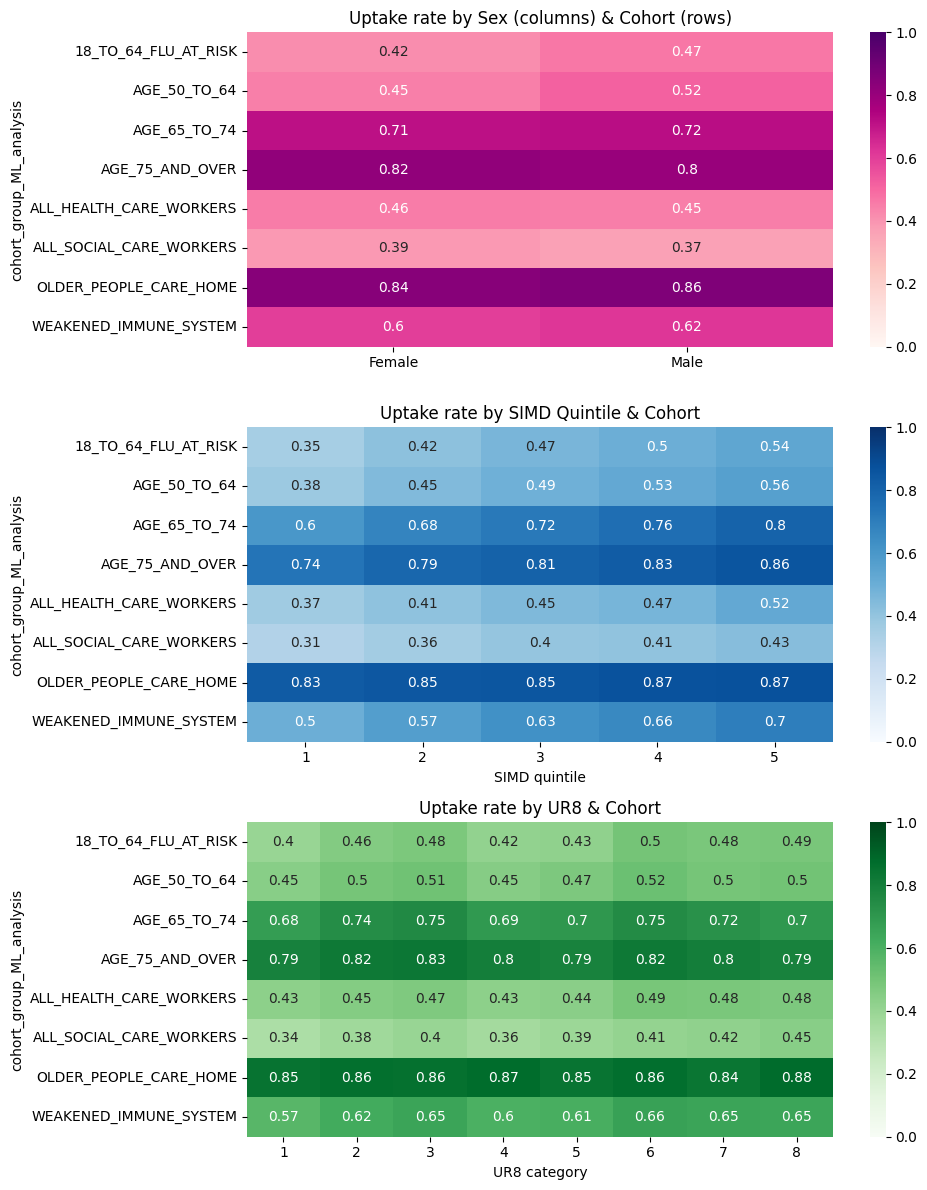

/tmp/ipykernel_2612/2627281881.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df.groupby(['cohort_group_ML_analysis', 'age_mid'])['attended_vaccination_event'].mean().reset_index()


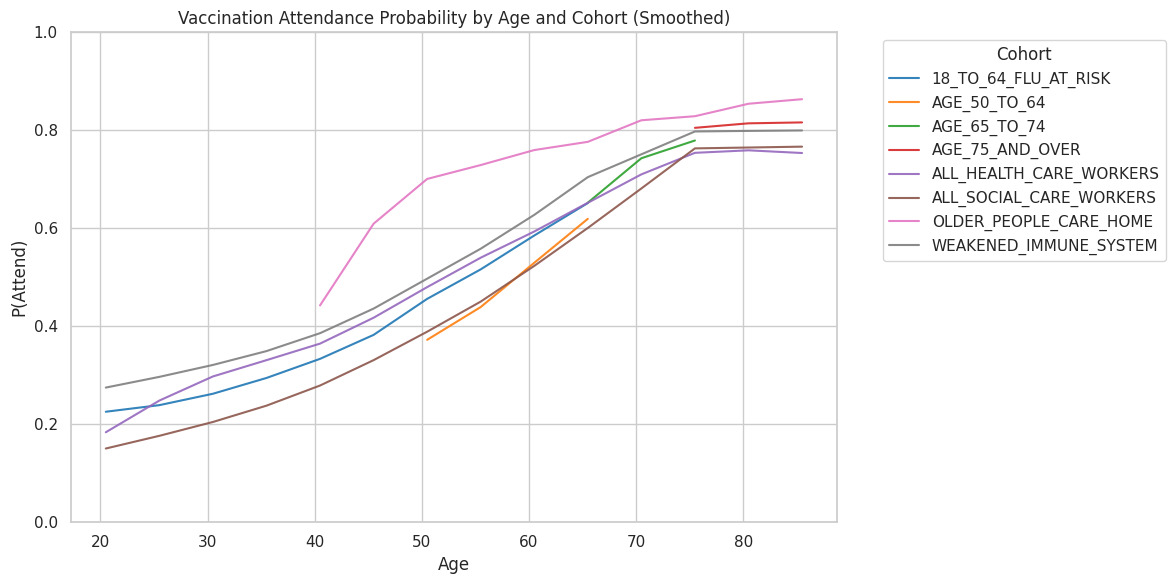

In [6]:
# Prepare pivot tables
sex_pivot = df.pivot_table(index='cohort_group_ML_analysis', columns='patient_sex', values='attended_vaccination_event', aggfunc='mean')
sex_pivot.columns = ['Female','Male']
 
simd_pivot = df.pivot_table(index='cohort_group_ML_analysis', columns='SIMD_quintile', values='attended_vaccination_event', aggfunc='mean')
 
ur8_pivot = df.pivot_table(index='cohort_group_ML_analysis', columns='UR8_2022', values='attended_vaccination_event', aggfunc='mean')
 
# Plot combined heatmaps
fig, axes = plt.subplots(3,1, figsize=(10,12), sharex=False)
 
sns.heatmap(sex_pivot, annot=True, cmap='RdPu', vmin=0, vmax=1, ax=axes[0])
axes[0].set_title('Uptake rate by Sex (columns) & Cohort (rows)')
axes[0].set_xlabel('')
 
sns.heatmap(simd_pivot, annot=True, cmap='Blues', vmin=0, vmax=1, ax=axes[1])
axes[1].set_title('Uptake rate by SIMD Quintile & Cohort')
axes[1].set_xlabel('SIMD quintile')
 
sns.heatmap(ur8_pivot, annot=True, cmap='Greens', vmin=0, vmax=1, ax=axes[2])
axes[2].set_title('Uptake rate by UR8 & Cohort')
axes[2].set_xlabel('UR8 category')
 
plt.tight_layout()
plt.savefig("FULL_COHORT_ANALYSIS_Heatmaps_and_uptake_rates.png")
plt.show()

# Bin ages for smoother plotting
df['age_bin'] = pd.cut(df['patient_age'], bins=np.arange(18, 91, 5), right=False)
df['age_mid'] = df['age_bin'].apply(lambda x: x.left + 2.5)

# Calculate attendance probability by age and cohort
rate = df.groupby(['cohort_group_ML_analysis', 'age_mid'])['attended_vaccination_event'].mean().reset_index()

# Plot with LOWESS smoothing to reduce overlap
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

palette = sns.color_palette("tab10", n_colors=len(cohorts))

for i, cohort in enumerate(rate['cohort_group_ML_analysis'].unique()):
    cohort_data = rate[rate['cohort_group_ML_analysis'] == cohort]
    smoothed = lowess(cohort_data['attended_vaccination_event'], cohort_data['age_mid'], frac=0.3)
    plt.plot(smoothed[:, 0], smoothed[:, 1], label=cohort, color=palette[i], alpha=0.9)

plt.xlabel('Age')
plt.ylabel('P(Attend)')
plt.title('Vaccination Attendance Probability by Age and Cohort (Smoothed)')
plt.ylim(0, 1)
plt.legend(title='Cohort', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("FULL_COHORT_ANALYSIS_Vaccination_Attendance_Probability_by_age_and_cohort.png")
plt.show()
 

<Axes: xlabel='UR8_2022'>

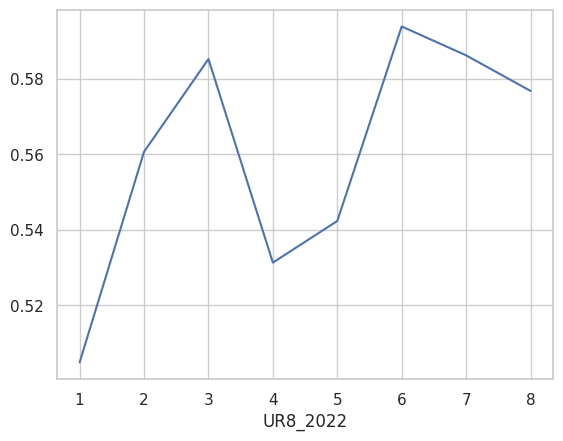

In [7]:
df.groupby("UR8_2022")["attended_vaccination_event"].mean().plot()


<Axes: xlabel='SIMD_quintile'>

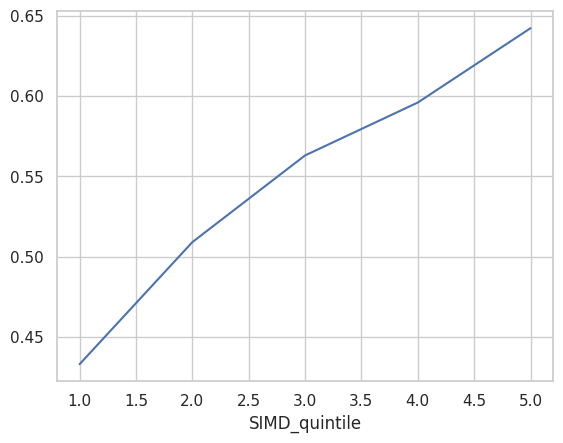

In [8]:
df.groupby("SIMD_quintile")["attended_vaccination_event"].mean().plot()